## In this notebook we will explore the control problem
 - Control problem improves the policy being evaluated
 - MDP is not known, so agent interacts with the environment sequentially
 - Target Policy: Policy that agent wants to learn
 - Behavioural Policy: Policy used to collect data by interacting with env
 - Policy improvement (Control) happens w.r.t value function in policy evaluation phase

### GPI (Generalized Policy improvement) for Control problems
- Loop: { Policy evaluation , Policy improvement}
    - Policy improvement is greedy policy with respect to value function
    - Greedy policy improvement works when complete MDP of environment is known
- When MDP is not known, we can still use GPI to solve
    - Policy evaluation methods: MC (first visit/Every visit), TD($\lambda$)
    - Policy improvement: CANNOT be completley greedy with respect to value function, we need to explore since MDP not known
- Two main changes for solving control problems when MDP not known
    - We estimate action values fuction Q(s,a)
    - We use epsilon-greedy policy improvement instead of completly greedy policy improvement    

### Monte Carlo control method 
- start with any policy
- Use MC (first visit/ every visit) for policy evaluation
- Policy improvement based on $\epsilon$-greedy 
    - Policy improvement step can take place after all episodes are finished (akin to policy iteration)
    - Policy improvement step can take place at the end of every episode (akin to value iteration)
    
- **NOTE** We will improve policy at the end of every episode (akin value iteration)

In [3]:
import gym
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline

np.random.seed(0)

In [4]:
env = gym.make("FrozenLake8x8-v0")

In [5]:
# borrowed from my notebook : Prediction-MC-TD.ipynb
def gen_trajectory(pi, env, maxsteps):
    '''
    [1] pi: policy
    [2] env: environment
    [3] maxsteps: maximum number of steps to be taken
    '''
    done = False
    stepcount = 0
    s = env.reset()
    trajectory = []
    while not done:
        stepcount += 1
        next_state, reward, done, info = env.step(pi[s])
        experience = (s, pi[s], reward, next_state, done)
        trajectory.append(experience)
        if done or stepcount >= maxsteps:
            break
        s = next_state
    return trajectory

def learningrate_schedule(start_alpha, min_alpha, max_episodes):
    '''
    [1] start_alpha :learning rate at the start of episode
    [2] min_alpha: minimum learning rate
    [3] max_episodes: maximum number of episodes
    '''    
    t = np.arange(0,max_episodes)
    alpha_s, alpha_f  = start_alpha, min_alpha
    assert max_episodes > 1
    alpha_sch = alpha_s * (alpha_f/alpha_s)**(t/(max_episodes-1))
    return alpha_sch
test = 0
if test==1:
    alpha_sch = learningrate_schedule(start_alpha=0.6, min_alpha=0.1, max_episodes=1000)
    plt.figure()
    plt.plot(alpha_sch)    
    
       

In [4]:
def MC_control(pi, env, gamma=1.0, start_alpha=0.5, min_alpha=0.1, espilon_start=1.0, epsilon_end=0.1, \
               max_episodes=1000, maxsteps=200, first_visit=True):
    '''
    [1] pi: policy which needs to be evaluated
    [2] env: environment
    [3] gamma: discount factor
    [4] min_alpha: minimum learning rate
    [5] max_episodes: maximum episodes for MC
    [6] maxsteps: maximum number of steps for trajectory generation
    [7] first_visit: boolean flag to indicate First Visit version of MC prediction
    [8] espilon_start: start value of epsilon for epsilon greedy
    [9] epsilon_end: end value of espilon greedy
    '''
    nS = len(pi)
    nA = env.action_space.n
    Q = np.zeros((nS, nA))
    Q_track = np.zeros((max_episodes, nS, nA)) # action value function snapshot  for every episode, just for vis purpose
    pi_track = [] # keeps track of greedy policy at the end of every episode
    
    # generate learning rate schedule
    alpha_sch = learningrate_schedule(start_alpha, min_alpha, max_episodes) # this will be exponential decay schedule
    # epsilon rate schedule
    eps_sch = learningrate_schedule(espilon_start, epsilon_end, max_episodes) # this will be exponential decay schedule
    
    # lambda function to choose action based on epsilon-greedy
    choose_action = lambda qvals, eps: np.random.randint(nA) if np.random.random() <= eps else np.argmax(qvals)
    
    for ep in tqdm(range(max_episodes)):
        # generate trajectory
        trajectory = gen_trajectory(pi, env, maxsteps)
        visited = np.zeros(nS, dtype=np.bool) # reset the visited flag
        for t, experience in enumerate(trajectory):
            state, action, reward, next_state, _ = experience
            if visited[state]==1 and first_visit:
                continue
            visited[state] = True
            # compute the discounted return
            num_steps = len(trajectory[t:])
            gamma_seq = gamma**(np.arange(0,num_steps))
            reward_list = np.array([experience[2] for experience in trajectory[t:]])
            returns = np.sum(gamma_seq * reward_list) #G_{t:T} = sum( gamma_seq * undiscounted returns )
            # update the state value 
            Q[state, action] = Q[state, action] + alpha_sch[ep] * (returns - Q[state, action])
            
        # update V_track at the end of every episode
        Q_track[ep, :, :] = Q
        
        # update the policy using eps greedy (Policy improvement)        
        pi = {s: choose_action(Q[s,:], eps_sch[ep]) for s in range(nS)}
        
        # update greedy policy at the end of every episode
        pi_track.append({s: choose_action(Q[s,:], 0.0) for s in range(nS)})
        #print(f"episode :{ep}")
        
    return Q, Q_track, pi, pi_track, alpha_sch,eps_sch

In [11]:
# start with some random initial policy
pi_init = {s: np.random.randint(env.env.nA) for s in range(env.env.nS)}
Q, Q_track, pi_conv, pi_track, alpha_sch, eps_sch = MC_control(pi_init, env, gamma=1.0, start_alpha=0.5, min_alpha=0.1, \
                                                     espilon_start=1.0, epsilon_end=0.02, max_episodes=2_00_000, \
                                                     maxsteps=200, first_visit=True)

100%|█████████████████████████████████████████████████████████████████████████| 200000/200000 [21:59<00:00, 151.58it/s]


In [12]:
Q

array([[1.42616274e-01, 6.51265256e-02, 4.02276671e-01, 1.64282991e-01],
       [2.26365179e-01, 2.24955200e-01, 4.61089833e-01, 9.16310611e-02],
       [1.91725859e-01, 1.01871990e-01, 2.86803816e-01, 5.17446174e-01],
       [1.22929372e-01, 1.41903507e-01, 2.39615280e-01, 5.57566028e-01],
       [2.35587428e-01, 2.52314982e-01, 1.87901464e-01, 5.70546594e-01],
       [1.68105743e-01, 4.91167213e-01, 5.70939915e-01, 2.75256206e-01],
       [2.12687954e-01, 3.31057736e-01, 6.87467174e-01, 3.82020517e-01],
       [2.71049006e-01, 6.62017715e-01, 3.10187696e-01, 2.12789835e-01],
       [5.35431771e-02, 3.98510882e-01, 1.46747593e-01, 1.50799141e-01],
       [1.08899627e-01, 1.67839866e-01, 5.66001706e-01, 3.02360778e-01],
       [2.46552436e-01, 5.65539842e-02, 5.10750891e-01, 1.06464254e-01],
       [7.02741683e-02, 7.62170114e-02, 7.38422887e-02, 5.60602490e-01],
       [2.48015937e-01, 1.57475676e-01, 5.81892684e-01, 2.23370914e-01],
       [1.88104013e-01, 6.32183631e-01, 2.42684449e

In [20]:
### calculate average rewards over some episode based on some policy
def mean_rewards(pi, num_episodes, env):
    
    total_reward_list = []
    for ep in range(num_episodes):
        total_reward = 0
        s = env.reset() 
        done = False
        while not done:
            next_state, reward, done, info = env.step(pi[s])
            total_reward += reward
            s = next_state
            if done:
                print(f"ep:{ep}, reward:{reward}")
                total_reward_list.append(total_reward)
                break
    return np.array(total_reward_list).mean()

In [14]:
mean_rew_init_policy = mean_rewards(pi_init, num_episodes=1000, env=env)
mean_rew_conv_policy = mean_rewards(pi_conv, num_episodes=1000, env=env)

ep:0, reward:0.0
ep:1, reward:0.0
ep:2, reward:0.0
ep:3, reward:0.0
ep:4, reward:0.0
ep:5, reward:0.0
ep:6, reward:0.0
ep:7, reward:0.0
ep:8, reward:0.0
ep:9, reward:0.0
ep:10, reward:0.0
ep:11, reward:0.0
ep:12, reward:0.0
ep:13, reward:0.0
ep:14, reward:0.0
ep:15, reward:0.0
ep:16, reward:0.0
ep:17, reward:0.0
ep:18, reward:0.0
ep:19, reward:0.0
ep:20, reward:0.0
ep:21, reward:0.0
ep:22, reward:0.0
ep:23, reward:0.0
ep:24, reward:0.0
ep:25, reward:0.0
ep:26, reward:0.0
ep:27, reward:0.0
ep:28, reward:0.0
ep:29, reward:0.0
ep:30, reward:0.0
ep:31, reward:0.0
ep:32, reward:0.0
ep:33, reward:0.0
ep:34, reward:0.0
ep:35, reward:0.0
ep:36, reward:0.0
ep:37, reward:0.0
ep:38, reward:0.0
ep:39, reward:0.0
ep:40, reward:0.0
ep:41, reward:0.0
ep:42, reward:0.0
ep:43, reward:0.0
ep:44, reward:0.0
ep:45, reward:0.0
ep:46, reward:0.0
ep:47, reward:0.0
ep:48, reward:0.0
ep:49, reward:0.0
ep:50, reward:0.0
ep:51, reward:0.0
ep:52, reward:0.0
ep:53, reward:0.0
ep:54, reward:0.0
ep:55, reward:0.0
ep

ep:500, reward:0.0
ep:501, reward:0.0
ep:502, reward:0.0
ep:503, reward:0.0
ep:504, reward:0.0
ep:505, reward:0.0
ep:506, reward:0.0
ep:507, reward:0.0
ep:508, reward:0.0
ep:509, reward:0.0
ep:510, reward:0.0
ep:511, reward:0.0
ep:512, reward:0.0
ep:513, reward:0.0
ep:514, reward:0.0
ep:515, reward:0.0
ep:516, reward:0.0
ep:517, reward:0.0
ep:518, reward:0.0
ep:519, reward:0.0
ep:520, reward:0.0
ep:521, reward:0.0
ep:522, reward:0.0
ep:523, reward:0.0
ep:524, reward:0.0
ep:525, reward:0.0
ep:526, reward:0.0
ep:527, reward:0.0
ep:528, reward:0.0
ep:529, reward:0.0
ep:530, reward:0.0
ep:531, reward:0.0
ep:532, reward:0.0
ep:533, reward:0.0
ep:534, reward:0.0
ep:535, reward:0.0
ep:536, reward:0.0
ep:537, reward:0.0
ep:538, reward:0.0
ep:539, reward:0.0
ep:540, reward:0.0
ep:541, reward:0.0
ep:542, reward:0.0
ep:543, reward:0.0
ep:544, reward:0.0
ep:545, reward:0.0
ep:546, reward:0.0
ep:547, reward:0.0
ep:548, reward:0.0
ep:549, reward:0.0
ep:550, reward:0.0
ep:551, reward:0.0
ep:552, rewa

ep:965, reward:0.0
ep:966, reward:0.0
ep:967, reward:0.0
ep:968, reward:0.0
ep:969, reward:0.0
ep:970, reward:0.0
ep:971, reward:0.0
ep:972, reward:0.0
ep:973, reward:0.0
ep:974, reward:0.0
ep:975, reward:0.0
ep:976, reward:0.0
ep:977, reward:0.0
ep:978, reward:0.0
ep:979, reward:0.0
ep:980, reward:0.0
ep:981, reward:0.0
ep:982, reward:0.0
ep:983, reward:0.0
ep:984, reward:0.0
ep:985, reward:0.0
ep:986, reward:0.0
ep:987, reward:0.0
ep:988, reward:0.0
ep:989, reward:0.0
ep:990, reward:0.0
ep:991, reward:0.0
ep:992, reward:0.0
ep:993, reward:0.0
ep:994, reward:0.0
ep:995, reward:0.0
ep:996, reward:0.0
ep:997, reward:0.0
ep:998, reward:0.0
ep:999, reward:0.0
ep:0, reward:1.0
ep:1, reward:0.0
ep:2, reward:0.0
ep:3, reward:1.0
ep:4, reward:1.0
ep:5, reward:1.0
ep:6, reward:0.0
ep:7, reward:1.0
ep:8, reward:0.0
ep:9, reward:1.0
ep:10, reward:0.0
ep:11, reward:1.0
ep:12, reward:0.0
ep:13, reward:0.0
ep:14, reward:1.0
ep:15, reward:0.0
ep:16, reward:1.0
ep:17, reward:0.0
ep:18, reward:0.0
ep:

ep:432, reward:0.0
ep:433, reward:0.0
ep:434, reward:1.0
ep:435, reward:0.0
ep:436, reward:1.0
ep:437, reward:1.0
ep:438, reward:0.0
ep:439, reward:0.0
ep:440, reward:1.0
ep:441, reward:1.0
ep:442, reward:1.0
ep:443, reward:1.0
ep:444, reward:0.0
ep:445, reward:1.0
ep:446, reward:1.0
ep:447, reward:0.0
ep:448, reward:1.0
ep:449, reward:1.0
ep:450, reward:1.0
ep:451, reward:0.0
ep:452, reward:0.0
ep:453, reward:1.0
ep:454, reward:1.0
ep:455, reward:1.0
ep:456, reward:0.0
ep:457, reward:0.0
ep:458, reward:0.0
ep:459, reward:1.0
ep:460, reward:1.0
ep:461, reward:0.0
ep:462, reward:0.0
ep:463, reward:0.0
ep:464, reward:1.0
ep:465, reward:1.0
ep:466, reward:0.0
ep:467, reward:0.0
ep:468, reward:0.0
ep:469, reward:0.0
ep:470, reward:1.0
ep:471, reward:1.0
ep:472, reward:1.0
ep:473, reward:1.0
ep:474, reward:0.0
ep:475, reward:0.0
ep:476, reward:0.0
ep:477, reward:0.0
ep:478, reward:0.0
ep:479, reward:0.0
ep:480, reward:1.0
ep:481, reward:0.0
ep:482, reward:1.0
ep:483, reward:0.0
ep:484, rewa

ep:878, reward:0.0
ep:879, reward:0.0
ep:880, reward:1.0
ep:881, reward:0.0
ep:882, reward:1.0
ep:883, reward:0.0
ep:884, reward:0.0
ep:885, reward:1.0
ep:886, reward:1.0
ep:887, reward:1.0
ep:888, reward:0.0
ep:889, reward:0.0
ep:890, reward:0.0
ep:891, reward:1.0
ep:892, reward:1.0
ep:893, reward:1.0
ep:894, reward:1.0
ep:895, reward:0.0
ep:896, reward:1.0
ep:897, reward:0.0
ep:898, reward:1.0
ep:899, reward:0.0
ep:900, reward:0.0
ep:901, reward:1.0
ep:902, reward:1.0
ep:903, reward:0.0
ep:904, reward:0.0
ep:905, reward:0.0
ep:906, reward:0.0
ep:907, reward:1.0
ep:908, reward:0.0
ep:909, reward:1.0
ep:910, reward:0.0
ep:911, reward:1.0
ep:912, reward:1.0
ep:913, reward:0.0
ep:914, reward:1.0
ep:915, reward:1.0
ep:916, reward:0.0
ep:917, reward:1.0
ep:918, reward:1.0
ep:919, reward:1.0
ep:920, reward:1.0
ep:921, reward:0.0
ep:922, reward:1.0
ep:923, reward:0.0
ep:924, reward:1.0
ep:925, reward:1.0
ep:926, reward:1.0
ep:927, reward:1.0
ep:928, reward:1.0
ep:929, reward:0.0
ep:930, rewa

In [15]:
print(f"avg reward over {str(1000)} episodes for initial policy : {mean_rew_init_policy}")
print(f"avg reward over {str(1000)} episodes for converged policy : {mean_rew_conv_policy}")

avg reward over 1000 episodes for initial policy : 0.0
avg reward over 1000 episodes for converged policy : 0.506


In [16]:
mean_rew_conv_policy = mean_rewards(pi_track[-1], num_episodes=1000, env=env)
print(f"avg reward over {str(1000)} episodes for converged policy : {mean_rew_conv_policy}")

ep:0, reward:0.0
ep:1, reward:1.0
ep:2, reward:1.0
ep:3, reward:0.0
ep:4, reward:0.0
ep:5, reward:1.0
ep:6, reward:1.0
ep:7, reward:0.0
ep:8, reward:1.0
ep:9, reward:0.0
ep:10, reward:0.0
ep:11, reward:0.0
ep:12, reward:0.0
ep:13, reward:0.0
ep:14, reward:0.0
ep:15, reward:0.0
ep:16, reward:0.0
ep:17, reward:0.0
ep:18, reward:0.0
ep:19, reward:1.0
ep:20, reward:1.0
ep:21, reward:1.0
ep:22, reward:1.0
ep:23, reward:0.0
ep:24, reward:1.0
ep:25, reward:0.0
ep:26, reward:1.0
ep:27, reward:1.0
ep:28, reward:1.0
ep:29, reward:0.0
ep:30, reward:1.0
ep:31, reward:1.0
ep:32, reward:1.0
ep:33, reward:0.0
ep:34, reward:1.0
ep:35, reward:1.0
ep:36, reward:1.0
ep:37, reward:1.0
ep:38, reward:1.0
ep:39, reward:0.0
ep:40, reward:0.0
ep:41, reward:1.0
ep:42, reward:0.0
ep:43, reward:1.0
ep:44, reward:0.0
ep:45, reward:1.0
ep:46, reward:0.0
ep:47, reward:1.0
ep:48, reward:1.0
ep:49, reward:1.0
ep:50, reward:1.0
ep:51, reward:0.0
ep:52, reward:1.0
ep:53, reward:1.0
ep:54, reward:1.0
ep:55, reward:0.0
ep

ep:443, reward:1.0
ep:444, reward:0.0
ep:445, reward:1.0
ep:446, reward:0.0
ep:447, reward:1.0
ep:448, reward:1.0
ep:449, reward:1.0
ep:450, reward:0.0
ep:451, reward:1.0
ep:452, reward:0.0
ep:453, reward:1.0
ep:454, reward:1.0
ep:455, reward:1.0
ep:456, reward:0.0
ep:457, reward:1.0
ep:458, reward:0.0
ep:459, reward:0.0
ep:460, reward:1.0
ep:461, reward:1.0
ep:462, reward:1.0
ep:463, reward:0.0
ep:464, reward:0.0
ep:465, reward:0.0
ep:466, reward:1.0
ep:467, reward:1.0
ep:468, reward:1.0
ep:469, reward:0.0
ep:470, reward:1.0
ep:471, reward:1.0
ep:472, reward:1.0
ep:473, reward:0.0
ep:474, reward:0.0
ep:475, reward:1.0
ep:476, reward:0.0
ep:477, reward:0.0
ep:478, reward:1.0
ep:479, reward:1.0
ep:480, reward:0.0
ep:481, reward:1.0
ep:482, reward:1.0
ep:483, reward:1.0
ep:484, reward:1.0
ep:485, reward:0.0
ep:486, reward:1.0
ep:487, reward:1.0
ep:488, reward:1.0
ep:489, reward:1.0
ep:490, reward:0.0
ep:491, reward:1.0
ep:492, reward:1.0
ep:493, reward:0.0
ep:494, reward:1.0
ep:495, rewa

ep:890, reward:0.0
ep:891, reward:1.0
ep:892, reward:0.0
ep:893, reward:1.0
ep:894, reward:0.0
ep:895, reward:0.0
ep:896, reward:1.0
ep:897, reward:1.0
ep:898, reward:1.0
ep:899, reward:0.0
ep:900, reward:0.0
ep:901, reward:0.0
ep:902, reward:0.0
ep:903, reward:0.0
ep:904, reward:0.0
ep:905, reward:1.0
ep:906, reward:1.0
ep:907, reward:0.0
ep:908, reward:0.0
ep:909, reward:0.0
ep:910, reward:0.0
ep:911, reward:1.0
ep:912, reward:1.0
ep:913, reward:0.0
ep:914, reward:1.0
ep:915, reward:0.0
ep:916, reward:0.0
ep:917, reward:0.0
ep:918, reward:1.0
ep:919, reward:0.0
ep:920, reward:1.0
ep:921, reward:1.0
ep:922, reward:0.0
ep:923, reward:1.0
ep:924, reward:1.0
ep:925, reward:0.0
ep:926, reward:0.0
ep:927, reward:1.0
ep:928, reward:0.0
ep:929, reward:1.0
ep:930, reward:1.0
ep:931, reward:1.0
ep:932, reward:1.0
ep:933, reward:1.0
ep:934, reward:0.0
ep:935, reward:0.0
ep:936, reward:1.0
ep:937, reward:1.0
ep:938, reward:0.0
ep:939, reward:0.0
ep:940, reward:0.0
ep:941, reward:0.0
ep:942, rewa

#### As you can see, when using MC/TD control we can achieve success  ~ 50-55% as compared to policy/value iteration algos where succes rate was 85-90% when full MDP was known. Any random policy success rate is about 0-5%

###  SARSA 
- replace MC evaluation with TD
- we achieve what is called TD control

Below we replace MC evaluation with TD lambda

In [46]:
# this function implements the backward view of TD(/lambda)
def SARSA_lambda(pi, env, gamma=1.0, start_alpha=0.5, min_alpha=0.1, espilon_start=1.0, epsilon_end=0.1, \
                 max_episodes=1000, lambda_=0.3):
    '''
    [1] pi: policy which needs to be evaluated
    [2] env: environment
    [3] gamma: discount factor
    [4] min_alpha: minimum learning rate
    [5] max_episodes: maximum episodes for MC
    [6] lambda_: weight mix-in factor in TD(lambda)
    [7] espilon_start: start value of epsilon for epsilon greedy
    [8] epsilon_end: end value of espilon greedy
    '''
    nS = len(pi)
    nA = env.action_space.n
    Q = np.zeros((nS, nA))
    E = np.zeros((nS,nA)) # Eligibility trace
    Q_track = np.zeros((max_episodes, nS, nA)) # action value function snapshot  for every episode, just for vis purpose
    pi_track = [] # keeps track of greedy policy at the end of every episode
    
    # generate learning rate schedule 
    alpha_sch = learningrate_schedule(start_alpha, min_alpha, max_episodes) # this will be exponential decay schedule
    # epsilon rate schedule
    eps_sch = learningrate_schedule(espilon_start, epsilon_end, max_episodes) # this will be exponential decay schedule
    
    # lambda function to choose action based on epsilon-greedy
    choose_action = lambda qvals, eps: np.random.randint(nA) if np.random.random() <= eps else np.argmax(qvals)
    
    for ep in tqdm(range(max_episodes)):
        # initialize state and action
        state, done = env.reset(), False
        action = choose_action(Q[state,:], eps_sch[ep])
        E.fill(0) # reset Eligibility for new episode
        while not done:   
            E[state, action] += 1            
            next_state, reward, done, info = env.step(action)
            # choose next action based on eps-greedy
            next_action = choose_action(Q[next_state,:], eps_sch[ep])
            target = reward + gamma * Q[next_state, next_action] * (not done)
            # update all state action values based on eligibility
            Q = Q + alpha_sch[ep] *(target - Q[state, action]) * E
            # decay Eligibility vector
            E  = lambda_ * alpha_sch[ep] * E
            if done:
                break
            state, action = next_state, next_action
            
        Q_track[ep,:,:] = Q
        
               
        # update greedy policy at the end of every episode
        pi_track.append({s: choose_action(Q[s,:], 0.0) for s in range(nS)})
    
    # update the final converged policy       
    pi = {s: choose_action(Q[s,:], 0.0) for s in range(nS)}
                
    return Q, Q_track, pi, pi_track, alpha_sch, eps_sch   

In [51]:
# start with some random initial policy
pi_init = {s: np.random.randint(env.env.nA) for s in range(env.env.nS)}
Q, Q_track, pi_conv, pi_track, alpha_sch, eps_sch = SARSA_lambda(pi_init, env, gamma=1.0, start_alpha=0.5,\
                                                                 espilon_start=1.0, epsilon_end=0.02,\
                                                                 min_alpha=0.1, max_episodes=1_00_000, lambda_=0.3)

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [19:09<00:00, 86.96it/s]


In [52]:
Q

array([[0.55020411, 0.54627844, 0.54062979, 0.56493153],
       [0.47347524, 0.56602419, 0.51879168, 0.51180306],
       [0.52011018, 0.54363473, 0.57229165, 0.54066206],
       [0.55755586, 0.57950356, 0.56188382, 0.56152271],
       [0.49009682, 0.55577761, 0.56052055, 0.59442436],
       [0.54837531, 0.57161808, 0.60456393, 0.57842703],
       [0.57808702, 0.60869712, 0.5792164 , 0.57904927],
       [0.58562199, 0.56124509, 0.63562192, 0.56186976],
       [0.44440004, 0.44899827, 0.46545545, 0.56976917],
       [0.51927794, 0.4955589 , 0.55942238, 0.50978721],
       [0.52431187, 0.52197609, 0.53958463, 0.54903731],
       [0.37416972, 0.29099072, 0.25334718, 0.57858002],
       [0.48247541, 0.51321336, 0.51833219, 0.58810663],
       [0.5699326 , 0.55513086, 0.59441076, 0.56616712],
       [0.61107224, 0.5787142 , 0.60813807, 0.54932377],
       [0.60001284, 0.58934664, 0.65639792, 0.56716119],
       [0.4109396 , 0.41556737, 0.41278943, 0.55920674],
       [0.42978958, 0.44097027,

In [53]:
mean_rew_init_policy = mean_rewards(pi_init, num_episodes=1000, env=env)
mean_rew_conv_policy = mean_rewards(pi_conv, num_episodes=1000, env=env)

ep:0, reward:0.0
ep:1, reward:0.0
ep:2, reward:0.0
ep:3, reward:0.0
ep:4, reward:0.0
ep:5, reward:0.0
ep:6, reward:0.0
ep:7, reward:0.0
ep:8, reward:0.0
ep:9, reward:0.0
ep:10, reward:0.0
ep:11, reward:0.0
ep:12, reward:0.0
ep:13, reward:0.0
ep:14, reward:0.0
ep:15, reward:0.0
ep:16, reward:0.0
ep:17, reward:0.0
ep:18, reward:0.0
ep:19, reward:0.0
ep:20, reward:0.0
ep:21, reward:0.0
ep:22, reward:0.0
ep:23, reward:0.0
ep:24, reward:0.0
ep:25, reward:0.0
ep:26, reward:0.0
ep:27, reward:0.0
ep:28, reward:0.0
ep:29, reward:0.0
ep:30, reward:0.0
ep:31, reward:0.0
ep:32, reward:0.0
ep:33, reward:0.0
ep:34, reward:0.0
ep:35, reward:0.0
ep:36, reward:0.0
ep:37, reward:0.0
ep:38, reward:0.0
ep:39, reward:0.0
ep:40, reward:0.0
ep:41, reward:0.0
ep:42, reward:0.0
ep:43, reward:0.0
ep:44, reward:0.0
ep:45, reward:0.0
ep:46, reward:0.0
ep:47, reward:0.0
ep:48, reward:0.0
ep:49, reward:0.0
ep:50, reward:0.0
ep:51, reward:0.0
ep:52, reward:0.0
ep:53, reward:0.0
ep:54, reward:0.0
ep:55, reward:0.0
ep

ep:492, reward:0.0
ep:493, reward:0.0
ep:494, reward:0.0
ep:495, reward:0.0
ep:496, reward:0.0
ep:497, reward:0.0
ep:498, reward:0.0
ep:499, reward:0.0
ep:500, reward:0.0
ep:501, reward:0.0
ep:502, reward:0.0
ep:503, reward:0.0
ep:504, reward:0.0
ep:505, reward:0.0
ep:506, reward:0.0
ep:507, reward:0.0
ep:508, reward:0.0
ep:509, reward:0.0
ep:510, reward:0.0
ep:511, reward:0.0
ep:512, reward:0.0
ep:513, reward:0.0
ep:514, reward:0.0
ep:515, reward:0.0
ep:516, reward:0.0
ep:517, reward:0.0
ep:518, reward:0.0
ep:519, reward:0.0
ep:520, reward:0.0
ep:521, reward:0.0
ep:522, reward:0.0
ep:523, reward:0.0
ep:524, reward:0.0
ep:525, reward:0.0
ep:526, reward:0.0
ep:527, reward:0.0
ep:528, reward:0.0
ep:529, reward:0.0
ep:530, reward:0.0
ep:531, reward:0.0
ep:532, reward:0.0
ep:533, reward:0.0
ep:534, reward:0.0
ep:535, reward:0.0
ep:536, reward:0.0
ep:537, reward:0.0
ep:538, reward:0.0
ep:539, reward:0.0
ep:540, reward:0.0
ep:541, reward:0.0
ep:542, reward:0.0
ep:543, reward:0.0
ep:544, rewa

ep:7, reward:1.0
ep:8, reward:1.0
ep:9, reward:1.0
ep:10, reward:1.0
ep:11, reward:1.0
ep:12, reward:1.0
ep:13, reward:1.0
ep:14, reward:1.0
ep:15, reward:1.0
ep:16, reward:1.0
ep:17, reward:0.0
ep:18, reward:1.0
ep:19, reward:0.0
ep:20, reward:0.0
ep:21, reward:1.0
ep:22, reward:1.0
ep:23, reward:1.0
ep:24, reward:0.0
ep:25, reward:1.0
ep:26, reward:1.0
ep:27, reward:1.0
ep:28, reward:1.0
ep:29, reward:1.0
ep:30, reward:1.0
ep:31, reward:1.0
ep:32, reward:0.0
ep:33, reward:0.0
ep:34, reward:1.0
ep:35, reward:0.0
ep:36, reward:1.0
ep:37, reward:1.0
ep:38, reward:1.0
ep:39, reward:1.0
ep:40, reward:0.0
ep:41, reward:0.0
ep:42, reward:1.0
ep:43, reward:1.0
ep:44, reward:1.0
ep:45, reward:0.0
ep:46, reward:0.0
ep:47, reward:1.0
ep:48, reward:1.0
ep:49, reward:1.0
ep:50, reward:0.0
ep:51, reward:1.0
ep:52, reward:1.0
ep:53, reward:1.0
ep:54, reward:1.0
ep:55, reward:0.0
ep:56, reward:0.0
ep:57, reward:0.0
ep:58, reward:1.0
ep:59, reward:1.0
ep:60, reward:1.0
ep:61, reward:1.0
ep:62, reward

ep:452, reward:1.0
ep:453, reward:0.0
ep:454, reward:1.0
ep:455, reward:0.0
ep:456, reward:0.0
ep:457, reward:1.0
ep:458, reward:1.0
ep:459, reward:1.0
ep:460, reward:1.0
ep:461, reward:1.0
ep:462, reward:1.0
ep:463, reward:1.0
ep:464, reward:1.0
ep:465, reward:1.0
ep:466, reward:1.0
ep:467, reward:1.0
ep:468, reward:1.0
ep:469, reward:0.0
ep:470, reward:0.0
ep:471, reward:1.0
ep:472, reward:0.0
ep:473, reward:1.0
ep:474, reward:1.0
ep:475, reward:1.0
ep:476, reward:1.0
ep:477, reward:0.0
ep:478, reward:0.0
ep:479, reward:0.0
ep:480, reward:1.0
ep:481, reward:0.0
ep:482, reward:1.0
ep:483, reward:0.0
ep:484, reward:0.0
ep:485, reward:1.0
ep:486, reward:1.0
ep:487, reward:1.0
ep:488, reward:0.0
ep:489, reward:1.0
ep:490, reward:0.0
ep:491, reward:0.0
ep:492, reward:1.0
ep:493, reward:0.0
ep:494, reward:0.0
ep:495, reward:1.0
ep:496, reward:1.0
ep:497, reward:0.0
ep:498, reward:1.0
ep:499, reward:1.0
ep:500, reward:1.0
ep:501, reward:0.0
ep:502, reward:0.0
ep:503, reward:1.0
ep:504, rewa

ep:912, reward:1.0
ep:913, reward:0.0
ep:914, reward:1.0
ep:915, reward:1.0
ep:916, reward:1.0
ep:917, reward:1.0
ep:918, reward:1.0
ep:919, reward:1.0
ep:920, reward:1.0
ep:921, reward:1.0
ep:922, reward:1.0
ep:923, reward:1.0
ep:924, reward:1.0
ep:925, reward:1.0
ep:926, reward:0.0
ep:927, reward:0.0
ep:928, reward:1.0
ep:929, reward:1.0
ep:930, reward:0.0
ep:931, reward:1.0
ep:932, reward:1.0
ep:933, reward:0.0
ep:934, reward:0.0
ep:935, reward:1.0
ep:936, reward:1.0
ep:937, reward:1.0
ep:938, reward:1.0
ep:939, reward:1.0
ep:940, reward:0.0
ep:941, reward:0.0
ep:942, reward:1.0
ep:943, reward:1.0
ep:944, reward:1.0
ep:945, reward:1.0
ep:946, reward:0.0
ep:947, reward:1.0
ep:948, reward:1.0
ep:949, reward:1.0
ep:950, reward:1.0
ep:951, reward:1.0
ep:952, reward:1.0
ep:953, reward:1.0
ep:954, reward:1.0
ep:955, reward:1.0
ep:956, reward:0.0
ep:957, reward:0.0
ep:958, reward:1.0
ep:959, reward:1.0
ep:960, reward:0.0
ep:961, reward:1.0
ep:962, reward:0.0
ep:963, reward:1.0
ep:964, rewa

In [54]:
print(f"avg reward over {str(1000)} episodes for initial policy : {mean_rew_init_policy}")
print(f"avg reward over {str(1000)} episodes for converged policy : {mean_rew_conv_policy}")

avg reward over 1000 episodes for initial policy : 0.0
avg reward over 1000 episodes for converged policy : 0.703


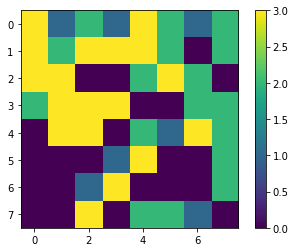

In [56]:
plt.figure()
plt.imshow(np.argmax(Q,axis=1).reshape(8,8))
plt.colorbar()

**SARSA($\lambda$) achieves  ~70% success rate**

### Q Learning
 - SARSA is online learning (on-policy: target policy and behavioural policy is the same)
    - Drawback of online learning is that you learn from your own current mistake
    - What if you want to learn from previous or someone else's mistake - cannot do with online learning
 - Here comes Q learning (off policy, target policy and behavioural policy is different)
 - The only difference b/w SARSA and Q leaning is that Q[s,a] bootstraps towards max_over_a` of Q[s`,a`]
  $$Q[s,a] = Q[s,a] + \alpha (reward + \gamma \max_{a'}Q[s',a'] - Q[s,a])$$ 
  
  where experience is (s,a,reward,s') and a' is the set of possible actions in state s`
 

In [76]:
# this function implements q learning agent
def qlearning(pi, env, gamma=1.0, start_alpha=0.5, min_alpha=0.1, espilon_start=1.0, epsilon_end=0.1, \
                 max_episodes=1000):
    '''
    [1] pi: policy which needs to be evaluated
    [2] env: environment
    [3] gamma: discount factor
    [4] min_alpha: minimum learning rate
    [5] max_episodes: maximum episodes for MC
    [6] espilon_start: start value of epsilon for epsilon greedy
    [7] epsilon_end: end value of espilon greedy
    '''
    nS = len(pi)
    nA = env.action_space.n
    Q = np.zeros((nS, nA))
    Q_track = np.zeros((max_episodes, nS, nA)) # action value function snapshot  for every episode, just for vis purpose
    pi_track = [] # keeps track of greedy policy at the end of every episode
    
    # generate learning rate schedule 
    alpha_sch = learningrate_schedule(start_alpha, min_alpha, max_episodes) # this will be exponential decay schedule
    # epsilon rate schedule
    eps_sch = learningrate_schedule(espilon_start, epsilon_end, max_episodes) # this will be exponential decay schedule
    
    # lambda function to choose action based on epsilon-greedy (behavioural or data/experience collection policy)
    choose_action = lambda qvals, eps: np.random.randint(nA) if np.random.random() <= eps else np.argmax(qvals)
    
    for ep in tqdm(range(max_episodes)):
        # initialize state and action
        state, done = env.reset(), False        
        while not done:   
            action = choose_action(Q[state,:], eps_sch[ep])
            next_state, reward, done, info = env.step(action)
            # choose max over actions for next_state,i.e. max(Q[next_state,:])
            max_next_state_qval = np.amax(Q[next_state, :])
            target = reward + gamma * max_next_state_qval * (not done)
            # update the state action value for the current state,action
            Q[state, action] = Q[state, action] + alpha_sch[ep] *(target - Q[state, action])
            if done:
                break
            state = next_state
            
            
        Q_track[ep,:,:] = Q
        
               
        # update greedy policy at the end of every episode
        pi_track.append({s: choose_action(Q[s,:], 0.0) for s in range(nS)})
    
    # update the final converged policy       
    pi = {s: choose_action(Q[s,:], 0.0) for s in range(nS)}
                
    return Q, Q_track, pi, pi_track, alpha_sch, eps_sch   

In [77]:
# start with some random initial policy
pi_init = {s: np.random.randint(env.env.nA) for s in range(env.env.nS)}
Q, Q_track, pi_conv, pi_track, alpha_sch, eps_sch = qlearning(pi_init, env, gamma=1.0, start_alpha=0.5, min_alpha=0.1,\
                                                              espilon_start=1.0, epsilon_end=0.02, max_episodes=1_00_000)

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [22:39<00:00, 73.53it/s]


In [78]:
Q

array([[0.50034076, 0.53053028, 0.580439  , 0.51483668],
       [0.54840436, 0.54469321, 0.58247064, 0.54740109],
       [0.53751   , 0.58273331, 0.51727583, 0.50230491],
       [0.51590313, 0.5820448 , 0.5341473 , 0.53282093],
       [0.5705785 , 0.58212369, 0.54448552, 0.53630074],
       [0.60581343, 0.58788983, 0.58671899, 0.59082233],
       [0.5976659 , 0.57807186, 0.60847531, 0.62864764],
       [0.60232077, 0.6518698 , 0.57778351, 0.58555983],
       [0.54330875, 0.535264  , 0.53932961, 0.58059272],
       [0.53382521, 0.53314165, 0.51839141, 0.58140285],
       [0.48662414, 0.49762413, 0.50075036, 0.58215498],
       [0.4999794 , 0.43530981, 0.49245966, 0.58012113],
       [0.54539334, 0.56848203, 0.53679353, 0.53581696],
       [0.56593925, 0.58746168, 0.6347863 , 0.5520107 ],
       [0.59674438, 0.59551375, 0.65882871, 0.57188115],
       [0.58495126, 0.68362425, 0.59936178, 0.61757352],
       [0.52322033, 0.52367757, 0.5241176 , 0.52955488],
       [0.49535673, 0.49859173,

In [79]:
mean_rew_init_policy = mean_rewards(pi_init, num_episodes=1000, env=env)
mean_rew_conv_policy = mean_rewards(pi_conv, num_episodes=1000, env=env)

ep:0, reward:0.0
ep:1, reward:0.0
ep:2, reward:0.0
ep:3, reward:0.0
ep:4, reward:0.0
ep:5, reward:0.0
ep:6, reward:0.0
ep:7, reward:0.0
ep:8, reward:0.0
ep:9, reward:0.0
ep:10, reward:0.0
ep:11, reward:0.0
ep:12, reward:0.0
ep:13, reward:0.0
ep:14, reward:0.0
ep:15, reward:0.0
ep:16, reward:0.0
ep:17, reward:0.0
ep:18, reward:0.0
ep:19, reward:0.0
ep:20, reward:0.0
ep:21, reward:0.0
ep:22, reward:0.0
ep:23, reward:0.0
ep:24, reward:0.0
ep:25, reward:0.0
ep:26, reward:0.0
ep:27, reward:0.0
ep:28, reward:0.0
ep:29, reward:0.0
ep:30, reward:0.0
ep:31, reward:0.0
ep:32, reward:0.0
ep:33, reward:0.0
ep:34, reward:0.0
ep:35, reward:0.0
ep:36, reward:0.0
ep:37, reward:0.0
ep:38, reward:0.0
ep:39, reward:0.0
ep:40, reward:0.0
ep:41, reward:0.0
ep:42, reward:0.0
ep:43, reward:0.0
ep:44, reward:0.0
ep:45, reward:0.0
ep:46, reward:0.0
ep:47, reward:0.0
ep:48, reward:0.0
ep:49, reward:0.0
ep:50, reward:0.0
ep:51, reward:0.0
ep:52, reward:0.0
ep:53, reward:0.0
ep:54, reward:0.0
ep:55, reward:0.0
ep

ep:438, reward:0.0
ep:439, reward:0.0
ep:440, reward:0.0
ep:441, reward:0.0
ep:442, reward:0.0
ep:443, reward:0.0
ep:444, reward:0.0
ep:445, reward:0.0
ep:446, reward:0.0
ep:447, reward:0.0
ep:448, reward:0.0
ep:449, reward:0.0
ep:450, reward:0.0
ep:451, reward:0.0
ep:452, reward:0.0
ep:453, reward:0.0
ep:454, reward:0.0
ep:455, reward:0.0
ep:456, reward:0.0
ep:457, reward:0.0
ep:458, reward:0.0
ep:459, reward:0.0
ep:460, reward:0.0
ep:461, reward:0.0
ep:462, reward:0.0
ep:463, reward:0.0
ep:464, reward:0.0
ep:465, reward:0.0
ep:466, reward:0.0
ep:467, reward:0.0
ep:468, reward:0.0
ep:469, reward:0.0
ep:470, reward:0.0
ep:471, reward:0.0
ep:472, reward:0.0
ep:473, reward:0.0
ep:474, reward:0.0
ep:475, reward:0.0
ep:476, reward:0.0
ep:477, reward:0.0
ep:478, reward:0.0
ep:479, reward:0.0
ep:480, reward:0.0
ep:481, reward:0.0
ep:482, reward:0.0
ep:483, reward:0.0
ep:484, reward:0.0
ep:485, reward:0.0
ep:486, reward:0.0
ep:487, reward:0.0
ep:488, reward:0.0
ep:489, reward:0.0
ep:490, rewa

ep:883, reward:0.0
ep:884, reward:0.0
ep:885, reward:0.0
ep:886, reward:0.0
ep:887, reward:0.0
ep:888, reward:0.0
ep:889, reward:0.0
ep:890, reward:0.0
ep:891, reward:0.0
ep:892, reward:0.0
ep:893, reward:0.0
ep:894, reward:0.0
ep:895, reward:0.0
ep:896, reward:0.0
ep:897, reward:0.0
ep:898, reward:0.0
ep:899, reward:0.0
ep:900, reward:0.0
ep:901, reward:0.0
ep:902, reward:0.0
ep:903, reward:0.0
ep:904, reward:0.0
ep:905, reward:0.0
ep:906, reward:0.0
ep:907, reward:0.0
ep:908, reward:0.0
ep:909, reward:0.0
ep:910, reward:0.0
ep:911, reward:0.0
ep:912, reward:0.0
ep:913, reward:0.0
ep:914, reward:0.0
ep:915, reward:0.0
ep:916, reward:0.0
ep:917, reward:0.0
ep:918, reward:0.0
ep:919, reward:0.0
ep:920, reward:0.0
ep:921, reward:0.0
ep:922, reward:0.0
ep:923, reward:0.0
ep:924, reward:0.0
ep:925, reward:0.0
ep:926, reward:0.0
ep:927, reward:0.0
ep:928, reward:0.0
ep:929, reward:0.0
ep:930, reward:0.0
ep:931, reward:0.0
ep:932, reward:0.0
ep:933, reward:0.0
ep:934, reward:0.0
ep:935, rewa

ep:333, reward:1.0
ep:334, reward:1.0
ep:335, reward:0.0
ep:336, reward:1.0
ep:337, reward:0.0
ep:338, reward:0.0
ep:339, reward:1.0
ep:340, reward:1.0
ep:341, reward:1.0
ep:342, reward:1.0
ep:343, reward:1.0
ep:344, reward:1.0
ep:345, reward:0.0
ep:346, reward:1.0
ep:347, reward:0.0
ep:348, reward:0.0
ep:349, reward:1.0
ep:350, reward:1.0
ep:351, reward:0.0
ep:352, reward:1.0
ep:353, reward:1.0
ep:354, reward:1.0
ep:355, reward:1.0
ep:356, reward:1.0
ep:357, reward:1.0
ep:358, reward:0.0
ep:359, reward:1.0
ep:360, reward:0.0
ep:361, reward:1.0
ep:362, reward:0.0
ep:363, reward:0.0
ep:364, reward:1.0
ep:365, reward:0.0
ep:366, reward:1.0
ep:367, reward:1.0
ep:368, reward:1.0
ep:369, reward:1.0
ep:370, reward:0.0
ep:371, reward:0.0
ep:372, reward:0.0
ep:373, reward:1.0
ep:374, reward:1.0
ep:375, reward:1.0
ep:376, reward:0.0
ep:377, reward:0.0
ep:378, reward:1.0
ep:379, reward:0.0
ep:380, reward:1.0
ep:381, reward:1.0
ep:382, reward:0.0
ep:383, reward:0.0
ep:384, reward:1.0
ep:385, rewa

ep:796, reward:0.0
ep:797, reward:0.0
ep:798, reward:0.0
ep:799, reward:1.0
ep:800, reward:0.0
ep:801, reward:0.0
ep:802, reward:0.0
ep:803, reward:0.0
ep:804, reward:1.0
ep:805, reward:1.0
ep:806, reward:1.0
ep:807, reward:1.0
ep:808, reward:1.0
ep:809, reward:1.0
ep:810, reward:0.0
ep:811, reward:0.0
ep:812, reward:1.0
ep:813, reward:0.0
ep:814, reward:1.0
ep:815, reward:0.0
ep:816, reward:0.0
ep:817, reward:0.0
ep:818, reward:1.0
ep:819, reward:0.0
ep:820, reward:0.0
ep:821, reward:0.0
ep:822, reward:1.0
ep:823, reward:1.0
ep:824, reward:1.0
ep:825, reward:0.0
ep:826, reward:1.0
ep:827, reward:1.0
ep:828, reward:0.0
ep:829, reward:0.0
ep:830, reward:1.0
ep:831, reward:0.0
ep:832, reward:1.0
ep:833, reward:1.0
ep:834, reward:1.0
ep:835, reward:0.0
ep:836, reward:1.0
ep:837, reward:1.0
ep:838, reward:1.0
ep:839, reward:1.0
ep:840, reward:1.0
ep:841, reward:0.0
ep:842, reward:0.0
ep:843, reward:1.0
ep:844, reward:0.0
ep:845, reward:1.0
ep:846, reward:1.0
ep:847, reward:1.0
ep:848, rewa

In [80]:
print(f"avg reward over {str(1000)} episodes for initial policy : {mean_rew_init_policy}")
print(f"avg reward over {str(1000)} episodes for converged policy : {mean_rew_conv_policy}")

avg reward over 1000 episodes for initial policy : 0.0
avg reward over 1000 episodes for converged policy : 0.532


In [81]:
# save the final Q values from q learning
Qvals_qlearning = Q

### Double Q learning
- Problem with Q learning is that it overestimates the Q values because our target  policy is max over all actions in next state
    - Taking Max creates bias
    - If bias is same across all states, then overestimation is not a problem, however it is not True
- Double Q learning tries to lower the bias in action values function of q learning agent

In [82]:
# this function implements q learning agent
def doubleqlearning(pi, env, gamma=1.0, start_alpha=0.5, min_alpha=0.1, espilon_start=1.0, epsilon_end=0.1, \
                 max_episodes=1000):
    '''
    [1] pi: policy which needs to be evaluated
    [2] env: environment
    [3] gamma: discount factor
    [4] min_alpha: minimum learning rate
    [5] max_episodes: maximum episodes for MC
    [6] espilon_start: start value of epsilon for epsilon greedy
    [7] epsilon_end: end value of espilon greedy
    '''
    nS = len(pi)
    nA = env.action_space.n
    Q1 = np.zeros((nS, nA))
    Q1_track = np.zeros((max_episodes, nS, nA)) # action value function snapshot  for every episode, just for vis purpose
    Q2 = np.zeros((nS, nA))
    Q2_track = np.zeros((max_episodes, nS, nA)) # action value function snapshot  for every episode, just for vis purpose
    pi_track = [] # keeps track of greedy policy at the end of every episode
    
    # generate learning rate schedule 
    alpha_sch = learningrate_schedule(start_alpha, min_alpha, max_episodes) # this will be exponential decay schedule
    # epsilon rate schedule
    eps_sch = learningrate_schedule(espilon_start, epsilon_end, max_episodes) # this will be exponential decay schedule
    
    # lambda function to choose action based on epsilon-greedy (behavioural or data/experience collection policy)
    choose_action = lambda qvals, eps: np.random.randint(nA) if np.random.random() <= eps else np.argmax(qvals)
    
    for ep in tqdm(range(max_episodes)):
        # initialize state and action
        state, done = env.reset(), False        
        while not done:
            action = choose_action((Q1[state,:] + Q2[state,:])/2, eps_sch[ep]) # choose action using avg of Q1 and Q2
            next_state, reward, done, info = env.step(action)
            
            # do a toss
            if np.random.randint(2):                
                # choose best action using Q2
                best_action = np.argmax(Q2[next_state, :]) # best action is chosen using Q2
                target = reward + gamma * np.amax(Q1[next_state, best_action]) * (not done) # action value is based on Q1
                # update the state action value for the current state,action for Q1
                Q1[state, action] = Q1[state, action] + alpha_sch[ep] *(target - Q1[state, action])
            else:
                # choose best action using Q1
                best_action = np.argmax(Q1[next_state, :]) # best action is chosen using Q1
                target = reward + gamma * np.amax(Q2[next_state, best_action]) * (not done) # action value is based on Q2
                # update the state action value for the current state,action for Q1
                Q2[state, action] = Q2[state, action] + alpha_sch[ep] *(target - Q2[state, action])
                
            if done:
                break
                
            state = next_state
            
            
        Q1_track[ep,:,:] = Q1
        Q2_track[ep,:,:] = Q2
        
               
        # update greedy policy at the end of every episode
        pi_track.append({s: choose_action((Q1[s,:] + Q2[s,:])/2, 0.0) for s in range(nS)})
    
    # update the final converged policy       
    pi = {s: choose_action((Q1[s,:]+Q2[s,:])/2, 0.0) for s in range(nS)}
                
    return Q1, Q2, Q1_track, Q2_track, pi, pi_track, alpha_sch, eps_sch   

In [83]:
# start with some random initial policy
pi_init = {s: np.random.randint(env.env.nA) for s in range(env.env.nS)}
Q1, Q2, Q1_track, Q2_track, pi_conv, pi_track, alpha_sch, eps_sch = doubleqlearning(pi_init, env, \
                                                                    gamma=1.0, start_alpha=0.5, min_alpha=0.1,\
                                                                    espilon_start=1.0, epsilon_end=0.1, max_episodes=1_00_000)

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [27:51<00:00, 59.83it/s]


In [85]:
Qavg = (Q1+Q2)/2
Qavg

array([[0.43368463, 0.43389023, 0.43490622, 0.44407079],
       [0.44235182, 0.44286891, 0.44318972, 0.44575043],
       [0.45043253, 0.45011633, 0.45062865, 0.45116446],
       [0.45926231, 0.45997121, 0.45980682, 0.45936409],
       [0.46339884, 0.46362659, 0.46346724, 0.46339142],
       [0.46952186, 0.47431105, 0.46961395, 0.4696559 ],
       [0.47589935, 0.47708176, 0.48760072, 0.47698245],
       [0.49675805, 0.48329304, 0.48325853, 0.48055098],
       [0.43016563, 0.43041687, 0.43070211, 0.43373491],
       [0.43526003, 0.4352953 , 0.43582956, 0.44029889],
       [0.44510194, 0.44024169, 0.44451101, 0.44691009],
       [0.33805917, 0.3382363 , 0.29942554, 0.45472328],
       [0.45252481, 0.43540591, 0.45519686, 0.4615823 ],
       [0.4666039 , 0.46596636, 0.45708889, 0.47097245],
       [0.48644245, 0.48481846, 0.5100381 , 0.48394938],
       [0.49703388, 0.50011012, 0.5208458 , 0.48936017],
       [0.42361419, 0.42336991, 0.42263672, 0.42436532],
       [0.41114126, 0.37031137,

In [86]:
mean_rew_init_policy = mean_rewards(pi_init, num_episodes=1000, env=env)
mean_rew_conv_policy = mean_rewards(pi_conv, num_episodes=1000, env=env)

ep:0, reward:0.0
ep:1, reward:0.0
ep:2, reward:0.0
ep:3, reward:0.0
ep:4, reward:0.0
ep:5, reward:0.0
ep:6, reward:0.0
ep:7, reward:0.0
ep:8, reward:0.0
ep:9, reward:0.0
ep:10, reward:0.0
ep:11, reward:0.0
ep:12, reward:0.0
ep:13, reward:0.0
ep:14, reward:0.0
ep:15, reward:0.0
ep:16, reward:0.0
ep:17, reward:0.0
ep:18, reward:0.0
ep:19, reward:0.0
ep:20, reward:0.0
ep:21, reward:0.0
ep:22, reward:0.0
ep:23, reward:0.0
ep:24, reward:0.0
ep:25, reward:0.0
ep:26, reward:0.0
ep:27, reward:0.0
ep:28, reward:0.0
ep:29, reward:0.0
ep:30, reward:0.0
ep:31, reward:0.0
ep:32, reward:0.0
ep:33, reward:0.0
ep:34, reward:0.0
ep:35, reward:0.0
ep:36, reward:0.0
ep:37, reward:0.0
ep:38, reward:0.0
ep:39, reward:0.0
ep:40, reward:0.0
ep:41, reward:0.0
ep:42, reward:0.0
ep:43, reward:0.0
ep:44, reward:0.0
ep:45, reward:0.0
ep:46, reward:0.0
ep:47, reward:0.0
ep:48, reward:0.0
ep:49, reward:0.0
ep:50, reward:0.0
ep:51, reward:0.0
ep:52, reward:0.0
ep:53, reward:0.0
ep:54, reward:0.0
ep:55, reward:0.0
ep

ep:467, reward:0.0
ep:468, reward:0.0
ep:469, reward:0.0
ep:470, reward:0.0
ep:471, reward:0.0
ep:472, reward:0.0
ep:473, reward:0.0
ep:474, reward:0.0
ep:475, reward:0.0
ep:476, reward:0.0
ep:477, reward:0.0
ep:478, reward:0.0
ep:479, reward:0.0
ep:480, reward:0.0
ep:481, reward:0.0
ep:482, reward:0.0
ep:483, reward:0.0
ep:484, reward:0.0
ep:485, reward:0.0
ep:486, reward:0.0
ep:487, reward:0.0
ep:488, reward:0.0
ep:489, reward:0.0
ep:490, reward:0.0
ep:491, reward:0.0
ep:492, reward:0.0
ep:493, reward:0.0
ep:494, reward:0.0
ep:495, reward:0.0
ep:496, reward:0.0
ep:497, reward:0.0
ep:498, reward:0.0
ep:499, reward:0.0
ep:500, reward:0.0
ep:501, reward:0.0
ep:502, reward:0.0
ep:503, reward:0.0
ep:504, reward:0.0
ep:505, reward:0.0
ep:506, reward:0.0
ep:507, reward:0.0
ep:508, reward:0.0
ep:509, reward:0.0
ep:510, reward:0.0
ep:511, reward:0.0
ep:512, reward:0.0
ep:513, reward:0.0
ep:514, reward:0.0
ep:515, reward:0.0
ep:516, reward:0.0
ep:517, reward:0.0
ep:518, reward:0.0
ep:519, rewa

ep:948, reward:0.0
ep:949, reward:0.0
ep:950, reward:0.0
ep:951, reward:0.0
ep:952, reward:0.0
ep:953, reward:0.0
ep:954, reward:0.0
ep:955, reward:0.0
ep:956, reward:0.0
ep:957, reward:0.0
ep:958, reward:0.0
ep:959, reward:0.0
ep:960, reward:0.0
ep:961, reward:0.0
ep:962, reward:0.0
ep:963, reward:0.0
ep:964, reward:0.0
ep:965, reward:0.0
ep:966, reward:0.0
ep:967, reward:0.0
ep:968, reward:0.0
ep:969, reward:0.0
ep:970, reward:0.0
ep:971, reward:0.0
ep:972, reward:0.0
ep:973, reward:0.0
ep:974, reward:0.0
ep:975, reward:0.0
ep:976, reward:0.0
ep:977, reward:0.0
ep:978, reward:0.0
ep:979, reward:0.0
ep:980, reward:0.0
ep:981, reward:0.0
ep:982, reward:0.0
ep:983, reward:0.0
ep:984, reward:0.0
ep:985, reward:0.0
ep:986, reward:0.0
ep:987, reward:0.0
ep:988, reward:0.0
ep:989, reward:0.0
ep:990, reward:0.0
ep:991, reward:0.0
ep:992, reward:0.0
ep:993, reward:0.0
ep:994, reward:0.0
ep:995, reward:0.0
ep:996, reward:0.0
ep:997, reward:0.0
ep:998, reward:0.0
ep:999, reward:0.0
ep:0, reward

ep:400, reward:1.0
ep:401, reward:0.0
ep:402, reward:1.0
ep:403, reward:1.0
ep:404, reward:1.0
ep:405, reward:1.0
ep:406, reward:1.0
ep:407, reward:0.0
ep:408, reward:0.0
ep:409, reward:0.0
ep:410, reward:1.0
ep:411, reward:1.0
ep:412, reward:1.0
ep:413, reward:0.0
ep:414, reward:1.0
ep:415, reward:1.0
ep:416, reward:0.0
ep:417, reward:1.0
ep:418, reward:1.0
ep:419, reward:0.0
ep:420, reward:1.0
ep:421, reward:0.0
ep:422, reward:1.0
ep:423, reward:1.0
ep:424, reward:1.0
ep:425, reward:1.0
ep:426, reward:1.0
ep:427, reward:1.0
ep:428, reward:1.0
ep:429, reward:1.0
ep:430, reward:1.0
ep:431, reward:0.0
ep:432, reward:1.0
ep:433, reward:1.0
ep:434, reward:1.0
ep:435, reward:0.0
ep:436, reward:1.0
ep:437, reward:1.0
ep:438, reward:1.0
ep:439, reward:1.0
ep:440, reward:1.0
ep:441, reward:1.0
ep:442, reward:0.0
ep:443, reward:1.0
ep:444, reward:1.0
ep:445, reward:1.0
ep:446, reward:1.0
ep:447, reward:1.0
ep:448, reward:1.0
ep:449, reward:0.0
ep:450, reward:0.0
ep:451, reward:1.0
ep:452, rewa

ep:856, reward:1.0
ep:857, reward:1.0
ep:858, reward:1.0
ep:859, reward:0.0
ep:860, reward:1.0
ep:861, reward:0.0
ep:862, reward:0.0
ep:863, reward:1.0
ep:864, reward:1.0
ep:865, reward:0.0
ep:866, reward:1.0
ep:867, reward:1.0
ep:868, reward:1.0
ep:869, reward:0.0
ep:870, reward:1.0
ep:871, reward:1.0
ep:872, reward:1.0
ep:873, reward:1.0
ep:874, reward:1.0
ep:875, reward:1.0
ep:876, reward:1.0
ep:877, reward:1.0
ep:878, reward:0.0
ep:879, reward:1.0
ep:880, reward:1.0
ep:881, reward:1.0
ep:882, reward:0.0
ep:883, reward:0.0
ep:884, reward:1.0
ep:885, reward:0.0
ep:886, reward:1.0
ep:887, reward:1.0
ep:888, reward:1.0
ep:889, reward:0.0
ep:890, reward:1.0
ep:891, reward:0.0
ep:892, reward:1.0
ep:893, reward:1.0
ep:894, reward:1.0
ep:895, reward:0.0
ep:896, reward:1.0
ep:897, reward:0.0
ep:898, reward:1.0
ep:899, reward:1.0
ep:900, reward:0.0
ep:901, reward:0.0
ep:902, reward:1.0
ep:903, reward:0.0
ep:904, reward:1.0
ep:905, reward:1.0
ep:906, reward:1.0
ep:907, reward:1.0
ep:908, rewa

In [87]:
print(f"avg reward over {str(1000)} episodes for initial policy : {mean_rew_init_policy}")
print(f"avg reward over {str(1000)} episodes for converged policy : {mean_rew_conv_policy}")

avg reward over 1000 episodes for initial policy : 0.0
avg reward over 1000 episodes for converged policy : 0.766


In [88]:
Qvals_doubleqlearning = Qavg

Text(0.5, 1.0, 'Overestimation of optimal state values in qlearning vs. double-qlearning')

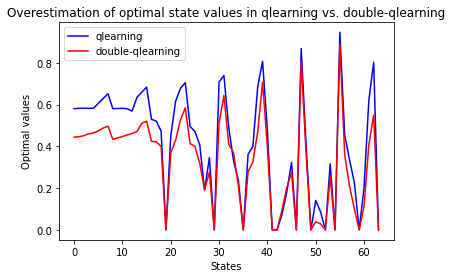

In [92]:
V_qlearning = np.amax(Qvals_qlearning, axis=1)
V_doubleqlearning = np.amax(Qvals_doubleqlearning, axis=1)
plt.figure()
plt.plot(V_qlearning, 'b-', label='qlearning')
plt.plot(V_doubleqlearning, 'r-', label='double-qlearning')
plt.legend()
plt.xlabel("States")
plt.ylabel("Optimal values")
plt.title("Overestimation of optimal state values in qlearning vs. double-qlearning")